# Convolutional Character Networks

    Convolutional Character Networks
    Linjie Xing, Zhi Tian, Weilin Huang, and Matthew R. Scott;
    In: Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2019.
    
Paper : https://arxiv.org/abs/1910.07954

Code : https://github.com/MalongTech/research-charnet

**Presentation**

Convolutional Character Networks (referred as CharNet)
- joint text detection and recognition
- by leveraging character as basic unit
- first one-stage CNN model for the joint tasks
- outperforms recent two stage approaches by a large margin,
- improvement of 65.33% -> 71.08% (generic lexicon) on ICDAR 2015
- improvement of 54.0% -> 69.23% (E2E) on Total-Text
- can achieve comparable results, e.g., 67.24% on ICDAR 2015, even without lexicon

CharNet
- direct character detection and recognition
- jointly with text instance (e.g., word) detection
- avoid limitations of current two-stage framework
  - RoI (Region of Interest) cropping and pooling
  - RNN-based word recognition
- simple, compact, yet powerful model
- directly outputs 
  - bounding boxes of words and characters
  - as well as the corresponding character labels

Drawbacks of 2 stages RoI cropping and pooling methods
- difficult to crop an accurate text region for feature pooling
- a large amount of background information may be included
- leads to significant performance degradation on recognition task
- particularly for multi-orientation or curved text

Advantages of characters detection over words detection
- word-level detection requires to cast text recognition into a sequence labelling problem
- a RNN model with additional modules, such as CTC or attention mechanism is needed (see below) 
- unlike English, words are not clearly distinguishable in some languages such as Chinese
- characters are more clearly-defined elements that generalize better over various languages
- character recognition is straightforward, and can be implemented with a simple CNN model

Drawbacks of RNN-based recognition methods
- word-level optimization with a sequential model
- significantly larger search space than direct character classification
- makes the models more complicated and difficult to train
- requires a significantly longer training time with a large amount of training samples




Iterative character detection method
- allows CharNet to transform the character detection capability learned from synthetic data to realworld images
- makes it possible for training CharNet on real-world images
- without providing additional charlevel bounding boxes

CharNet has a character branch that directly outputs accurate charlevel bounding boxes. 

This enables it to automatically identify characters, allowing it to work in a weakly-supervised manner by using the proposed iterative character detection.

This results in a distinct capability for training CharNet without additional char-level bounding boxes in real-world images

**Architecture**

Related works :
- in [41], EAST was introduced by exploring IOU loss [39] (Intersection over Union)

[39] J. Yu, Y. Jiang, Z. Wang, Z. Cao, and T. Huang. Unitbox: An advanced object detection network. In Proceedings of the 2016 ACM on Multimedia Conference, pages 516–520. ACM, 2016. 2

[41] X. Zhou, C. Yao, H. Wen, Y. Wang, S. Zhou, W. He, and J. Liang. East: an efficient and accurate scene text detector. In Proc. CVPR, pages 2642–2651, 2017.

CharNet overview :
- one-stage convolutional architecture
- consisting of two branches
- (1) a character branch designed for direct character detection and recognition
- (2) a text detection branch predicting a bounding box for each text instance in an image
- the two branches are implemented in parallel
- resulting in an end-to-end trainable model

CharNet output :
- instance-level bounding boxes
- char-level bounding boxes with character labels

CharNet backbones :
- ResNet-50 [8]
- Hourglass [19]

[8] K. He, X. Zhang, S. Ren, and J. Sun. Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition, pages 770–778, 2016.

[19] H. Law and J. Deng. Cornernet: Detecting objects as paired keypoints. In Proceedings of the European Conference on Computer Vision (ECCV), pages 734–
750, 2018.

ResNet-50 architecture (inspired by [41])
- final convolutional maps to implement text detection and recognition
- => convolutional feature maps with 4× down-sampling ratio
- results in high-resolution feature maps that enable CharNet to identify extremely small scale text instances

Hourglass architecture
- stack two hourglass modules
- final feature maps are up-sampled to 1/4 resolution of the input image
- Hourglass-88 is modified from Hourglass-104 in [19]
  - removing two downsampling stages
  - reducing the number of layers in the last stage of each hourglass module by half
  - do not employ the intermediate supervision
- Hourglass-57 is modified from Hourglass-88
  - further removing half number of layers in each stage of hourglass modules

**Character branch**

Uses character as basic unit for detection and recognition, and outputs char-level bounding boxes as well as the corresponding character labels.

- stack of convolutional layers, move densely over the feature maps
- input features maps = final feature maps of the backbone, with 1/4 spatial resolution of the input image
- three sub-branches, for text instance segmentation, character detection and character recognition
- all of the output feature maps from three sub-branches have the same spatial resolution, which is exactly the same as that of the input feature maps (1/4 of the input image)

Text instance segmentation
- three convolutional layers with filter sizes of 3×3, 3×3 and 1×1
- exploits a binary mask as supervision
- outputs 2-channel feature maps indicating text or non-text probability at each spatial location

Character detection
- three convolutional layers with filter sizes of 3×3, 3×3 and 1×1
- outputs 5-channel feature maps, estimating a character bounding box at each spatial location
- each character bounding box is parameterized by five parameters, indicating the distances of current location to the top, bottom, left and right sides of the bounding box (tblr), as well as the orientation of bounding-box (o)
(inspired by EAST [41])

Character recognition
- four convolutional layers with one more 3 × 3 convolutional layer
- character labels are predicted densely over the input feature maps, generating 68-channel probability maps
-  each channel is a probability map for a specific character class among 68 character classes, including 26 English characters, 10 digital numbers and 32 special symbols

The char-level bounding boxes are generated by keeping the bounding boxes having a confident value over 0.95. 

Each generated bounding box has a corresponding character label, which is computed at the corresponding spatial location from the 68-channel cassification maps - by using the maximum of the computed softmax scores.

**Text detection branch**

- designed to identify text instances at a higher level concept, such as words or textlines
- provides strong context information which is used to group the detected characters into text instances
- because directly grouping characters by using characters information (e.g., character locations or geometric features) is heuristic and complicated 
- particularly when multiple text instances are located closely within a region, or for text instances with multiple orientations or in a curved shape
- can be defined in different forms subjected to the type of text instances
- existing instance level text detectors can be adapted with minimum modification

Multi-Orientation Text
- simply modify EAST detector [41] as our text detection branch
- compute dense prediction at each spatial location of the feature maps
- two 3×3 convolutional layers, followed by another 1 × 1 convolutional layer
- contains two sub-branches 
  - text instance segmentation
    - outputs 2-channel feature maps indicating text or non-text probability
  - instance level bounding box regression using IoU loss
    - the predicted bounding boxes are parameterized by five parameters including 4 scalars for a bounding box with an orientation angle
    - outputs 5-channel detection maps for bounding boxes with orientation angles
- keep the bounding boxes having a confident value over 0.95

Curved Text
- we modify Textfield in [38]
- using a direction field, which encodes the direction information that points away from text boundary
- direction field is used to separate adjacent text instances
- can be predicted by a new branch in parallel with text detection branch and character branch
- branch is composed of two 3×3 convolutional layers, followed by another 1×1 convolutional layer

[38] Y. Xu, Y. Wang, W. Zhou, Y. Wang, Z. Yang, and X. Bai. Textfield: Learning a deep direction field for irregular scene text detection. IEEE Transactions on
Image Processing, 2019.

**Generation of final results**

- predicted instance level bounding boxes are applied to group the generated characters into text instances
- assigning a character to a text instance if the character bounding box have an overlap (e.g., with > 0 IoU) with an instance-level bounding box
- final outputs of our CharNet are bounding boxes of both text instances and characters, with the corresponding character labels

**Training**

Supervised training
- text instance level bounding boxes (ex words)
- char-level bounding boxes with character labels

Training character branch requires char-level bounding boxes with the corresponding character labels. 

Compared to word-level annotations, acquiring char-level labels with bounding boxes is much more expensive and would significantly increase labor cost. To avoid such additional cost, we use the iterative character detection mechanism described below.

Iterative learning approach for automatic character detection
1. learn a character detector from synthetic data, where full char-level annotations can be generated unlimitedly (supervised learning)
2. the learned character detection capability can be transformed and adapted gradually to real-word images (weakly-supervised learning)

We can train capability for identifying characters by leveraging synthetic data, such as Synth800k [7].

[7] A. Gupta, A. Vedaldi, and A. Zisserman. Synthetic data for text localisation in natural images. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 2315–2324, 2016.

A straightforward approach is to train our model directly with synthetic images, and then run inference on real-world images. However, it has a large domain gap between the synthetic images and real ones, and therefore the model
trained from synthetic images is difficult to work directly on the real-world ones : low performance is obtained on both text detection and E2E recognition.

We observed that a text detector has relatively stronger generalization capability than a text recognizer, which inspired us to explore the generalization ability of a character detector to bridge the gap between the two domains.

Our intuition is to gradually improve the generalization capability of model which is initially trained from synthetic images where full char-level annotations are provided, and the key is to transform the capability of character detection learned from the synthetic data to real-world images.

We develop an iterative process by gradually identifying the “correct” char-level bounding boxes from real-world images by the model itself. Note that instancelevel transcripts (e.g., words) are often provided in existing
datasets for E2E text recognition.

We make use of a simple rule that identifies a group of char-level bounding boxes as “correct” *if the number of character bounding boxes in a text
instance is exactly equal to the number of character labels in the provided instance-level transcript*.

- Train an initial model on synthetic data, where both char-level and instance-level annotations are available. 

- Apply the trained model to the training images from a real-world dataset with instance level transcripts provided
  - char-level bounding boxes are predicted by the learned model.
  - use the simple rule above to collect the “correct” char-level bounding boxes 
  - add these char-level bounding boxes to the ground truth of the real-worlds dataset
  - don't add the predicted character labels to the ground truth, which are not fully correct and would reduce the performance

- Use the "correct" bounding boxes to further train the model

- This process is repeated iteratively 
  - enhance the model capability gradually for character detection on the real world dataset
  - which in turn continuously improves the quality of the identified characters
  - with an increasing number of “correct” char-level bounding boxes generated

**Training details**

CharNet is trained on both synthetic data and real-world data. 

The proposed iterative character detection is implemented by using 4 iterative steps.

At the first step, CharNet is trained on synthetic data, Synth800k [7], where both char-level and word-level annotations are available
- 5 epochs
- mini-batch size of 32 images, with 4 images per GPU
- base learning rate of 0.0002, which is reduced according to lrbase × (1 − iter / max iter) ** power with power = 0.9

The remained three iterative steps are implemented on real-world data
- 100, 400 and 800 epochs respectively
- on the training set of a benchmark provided
- base learning rate of 0.002
- use the char-level bounding boxes generated by the model trained from the previous step

Use of similar data augmentation as FOTS [24] and OHEM [34].

[24] X. Liu, D. Liang, S. Yan, D. Chen, Y. Qiao, and J. Yan. Fots: Fast oriented text spotting with a unified network. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 5676–5685, 2018. => https://arxiv.org/abs/1801.01671

[34] A. Shrivastava, A. Gupta, and R. Girshick. Training region-based object detectors with online hard example mining. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition, pages 761–769, 2016. => https://arxiv.org/abs/1604.03540

With *multi-scale inference*, CharNet surpasses the previous best results.

## License

CharNet is CC-BY-NC 4.0 licensed, as found in the [LICENSE](LICENSE) file. It is released for academic research / non-commercial use only. If you wish to use for commercial purposes, please contact bd@malong.com.

## Prerequisites

In [8]:
# PyTorch GPU
#!conda install -y -c pytorch torch torchvision
# PyTorch CPU
#!conda install -y -c pytorch pytorch torchvision cpuonly

# Various dependencies
#!conda install -y ninja cython matplotlib tqdm scikit-image
#!conda install -y -c conda-forge opencv#-python
#!conda install -y -c conda-forge shapely editdistance pyclipper

## Pretrained weights

download_weights.sh [340.38M]

In [2]:
#!mkdir -p /storage/models/
#!wget https://cloudstor.aarnet.edu.au/plus/s/c0PaY4pzPUhPmL9/download -O ~/.fastai/models/icdar2015_hourglass88.pth

datasets/ICDAR2015/test/ [1M]

In [3]:
#!mkdir -p /storage/data/ICDAR2015/test/
#!wget https://raw.githubusercontent.com/MalongTech/research-charnet/master/datasets/ICDAR2015/test/char_dict.txt -O ~/.fastai/data/ICDAR2015/test/char_dict.txt
#!wget https://raw.githubusercontent.com/MalongTech/research-charnet/master/datasets/ICDAR2015/test/GenericVocabulary.txt -O ~/.fastai/data/ICDAR2015/test/GenericVocabulary.txt

## Sample data

**ICDAR 2015** [17]

ICDAR 2015 includes 1,500 images collected by  using Google Glasses. 

The training set has 1,000 images, and the remaining 500 images are used for evaluation.

This dataset is challenging due to the presence of multiorientated and very small-scale text instances.

[17 ] D. Karatzas, L. Gomez-Bigorda, A. Nicolaou, S. Ghosh, A. Bagdanov, M. Iwamura, J. Matas, L. Neumann, V. R. Chandrasekhar, S. Lu, et al. 

Icdar 2015 competition on robust reading. 

In Document Analysis and Recognition (ICDAR), 2015 13th International Conference on, pages 1156–1160. IEEE, 2015. 

https://rrc.cvc.uab.es/?ch=4

Paper : https://rrc.cvc.uab.es/files/short_rrc_2015.pdf

Presentation : https://rrc.cvc.uab.es/files/Robust_Reading_2015_v02.pdf

Task - Incidental scene text : https://rrc.cvc.uab.es/?ch=4&com=tasks

Downloads : https://rrc.cvc.uab.es/?ch=4&com=downloads [login = laurent.prudhon@hotmail.fr]

In [4]:
#!mkdir -p /storage/data/
#!wget "https://onedrive.live.com/download?cid=196F0B5AFCED95CA&resid=196F0B5AFCED95CA%21475665&authkey=AAYDavlPDNEaL1s" -O ~/.fastai/data/ICDAR2015.zip
# => unzip manually in a shell

 **Total-Text dataset** [5]
 
Total-Text consists of 1,555 images with a variety of text types including horizontal, multi-oriented, and curved text instances.

The training split and testing split have 1,255 images and 300 images, respectively. 
 
[5] C. K. Ch’ng and C. S. Chan. 

Total-text: A comprehensive dataset for scene text detection and recognition. 

In 2017 14th IAPR International Conference on Document Analysis and Recognition (ICDAR), volume 1, pages 935–942. IEEE, 2017.

**ICDAR MLT 2017** [27]

ICDAR MLT 2017 is a large-scale multi-lingual text dataset.

It contains 7,200 training images, 1,800 validation images, and 9,000 testing images. 9 languages are included in total.

[27] N. Nayef, F. Yin, I. Bizid, H. Choi, Y. Feng, D. Karatzas, Z. Luo, U. Pal, C. Rigaud, J. Chazalon, et al. 

Icdar2017 robust reading challenge on multilingual scene text detection and script identification-rrc-mlt. 

In Document Analysis and Recognition (ICDAR), 2017 14th IAPR International Conference on, volume 1, pages 1454–1459. IEEE, 2017.

## Post-processing - Model output decoder

**modeling/utils.py**

In [5]:
import math

def rotate_rect(x1, y1, x2, y2, degree, center_x, center_y):
    points = [[x1, y1], [x2, y1], [x2, y2], [x1, y2]]
    new_points = list()
    for point in points:
        dx = point[0] - center_x
        dy = point[1] - center_y
        new_x = center_x + dx * math.cos(degree) - dy * math.sin(degree)
        new_y = center_y + dx * math.sin(degree) + dy * math.cos(degree)
        new_points.append([(new_x), (new_y)])
    return new_points

**modeling/rotated_nms.py**

In [9]:
import numpy as np
import pyclipper
from shapely.geometry import Polygon


def nms(boxes, overlapThresh, neighbourThresh=0.5, minScore=0, num_neig=0):
    new_boxes = np.zeros_like(boxes)
    pick = []
    suppressed = [False for _ in range(boxes.shape[0])]
    areas = [Polygon([(b[0], b[1]), (b[2], b[3]), (b[4], b[5]), (b[6], b[7])]).area
             for b in boxes]
    polygons = pyclipper.scale_to_clipper(boxes[:, :8].reshape((-1, 4, 2)))
    order = boxes[:, 8].argsort()[::-1]
    for _i, i in enumerate(order):
        if suppressed[i] is False:
            pick.append(i)
            neighbours = list()
            for j in order[_i+1:]:
                if suppressed[j] is False:
                    try:
                        pc = pyclipper.Pyclipper()
                        pc.AddPath(polygons[i], pyclipper.PT_CLIP, True)
                        pc.AddPaths([polygons[j]], pyclipper.PT_SUBJECT, True)
                        solution = pc.Execute(pyclipper.CT_INTERSECTION)
                        if len(solution) == 0:
                            inter = 0
                        else:
                            inter = pyclipper.scale_from_clipper(
                                pyclipper.scale_from_clipper(
                                    pyclipper.Area(solution[0])))
                    except:
                        inter = 0
                    union = areas[i] + areas[j] - inter
                    iou = inter / union if union > 0 else 0
                    if union > 0 and iou > overlapThresh:
                        suppressed[j] = True
                    if iou > neighbourThresh:
                        neighbours.append(j)
            if len(neighbours) >= num_neig:
                neighbours.append(i)
                temp_scores = (boxes[neighbours, 8] - minScore).reshape((-1, 1))
                new_boxes[i, :8] = (boxes[neighbours, :8] * temp_scores).sum(axis=0) / temp_scores.sum()
                new_boxes[i, 8] = boxes[i, 8]
            else:
                for ni in neighbours:
                    suppressed[ni] = False
                pick.pop()
    return pick, new_boxes


def nms_with_char_cls(boxes, char_scores, overlapThresh, neighbourThresh=0.5, minScore=0, num_neig=0):
    new_boxes = np.zeros_like(boxes)
    new_char_scores = np.zeros_like(char_scores)
    pick = []
    suppressed = [False for _ in range(boxes.shape[0])]
    areas = [Polygon([(b[0], b[1]), (b[2], b[3]), (b[4], b[5]), (b[6], b[7])]).area
             for b in boxes]
    polygons = pyclipper.scale_to_clipper(boxes[:, :8].reshape((-1, 4, 2)))
    order = boxes[:, 8].argsort()[::-1]
    for _i, i in enumerate(order):
        if suppressed[i] is False:
            pick.append(i)
            neighbours = list()
            for j in order[_i+1:]:
                if suppressed[j] is False:
                    try:
                        pc = pyclipper.Pyclipper()
                        pc.AddPath(polygons[i], pyclipper.PT_CLIP, True)
                        pc.AddPaths([polygons[j]], pyclipper.PT_SUBJECT, True)
                        solution = pc.Execute(pyclipper.CT_INTERSECTION)
                        if len(solution) == 0:
                            inter = 0
                        else:
                            inter = pyclipper.scale_from_clipper(
                                pyclipper.scale_from_clipper(
                                    pyclipper.Area(solution[0])))
                    except:
                        inter = 0
                    union = areas[i] + areas[j] - inter
                    iou = inter / union if union > 0 else 0
                    if union > 0 and iou > overlapThresh:
                        suppressed[j] = True
                    if iou > neighbourThresh:
                        neighbours.append(j)
            if len(neighbours) >= num_neig:
                neighbours.append(i)
                temp_scores = (boxes[neighbours, 8] - minScore).reshape((-1, 1))
                new_boxes[i, :8] = (boxes[neighbours, :8] * temp_scores).sum(axis=0) / temp_scores.sum()
                new_boxes[i, 8] = boxes[i, 8]
                new_char_scores[i, :] = (char_scores[neighbours, :] * temp_scores).sum(axis=0) / temp_scores.sum()
            else:
                for ni in neighbours:
                    suppressed[ni] = False
                pick.pop()
    return pick, new_boxes, new_char_scores

# -- NOT USED --
def softnms(boxes, box_scores, char_scores=None, overlapThresh=0.3,
                          threshold=0.8, neighbourThresh=0.5, num_neig=0):
    scores = box_scores.copy()
    new_boxes = boxes[:, 0: 8].copy()
    if char_scores is not None:
        new_char_scores = char_scores.copy()
    polygons = [pyclipper.scale_to_clipper(poly.reshape((-1, 2))) for poly in new_boxes]
    areas = [pyclipper.scale_from_clipper(pyclipper.scale_from_clipper(
             pyclipper.Area(poly))) for poly in polygons]
    areas = [abs(_) for _ in areas]
    N = boxes.shape[0]
    order = np.arange(N)
    i = 0
    while i < N:
        max_pos = scores[order[i: N]].argmax() + i
        order[i], order[max_pos] = order[max_pos], order[i]
        pos = i + 1
        neighbours = list()
        while pos < N:
            try:
                pc = pyclipper.Pyclipper()
                pc.AddPath(polygons[order[i]], pyclipper.PT_CLIP, True)
                pc.AddPaths([polygons[order[pos]]], pyclipper.PT_SUBJECT, True)
                solution = pc.Execute(pyclipper.CT_INTERSECTION)
                if len(solution) == 0:
                    inter = 0
                else:
                    inter = pyclipper.scale_from_clipper(
                        pyclipper.scale_from_clipper(
                            pyclipper.Area(solution[0])))
            except Exception:
                inter = 0
            union = areas[order[i]] + areas[order[pos]] - inter
            iou = inter / union if union > 0 else 0
            if iou > neighbourThresh:
                neighbours.append(order[pos])
            weight = np.exp(-(iou **2) / 0.5)
            scores[order[pos]] *= weight
            if scores[order[pos]] < threshold:
                order[pos], order[N - 1] = order[N - 1], order[pos]
                N -= 1
                pos -= 1
            pos += 1
        if len(neighbours) >= num_neig:
            neighbours.append(order[i])
            temp_scores = box_scores[neighbours].reshape((-1, 1))
            new_boxes[order[i], :8] = (boxes[neighbours, :8] * temp_scores).sum(axis=0) / temp_scores.sum()
            if char_scores is not None:
                new_char_scores[order[i], :] = (char_scores[neighbours, :] * temp_scores).sum(axis=0) / temp_scores.sum()
        else:
            order[i], order[N - 1] = order[N - 1], order[i]
            N -= 1
            i -= 1
        i += 1
    keep = [order[_] for _ in range(N)]
    if char_scores is not None:
        return keep, new_boxes, new_char_scores
    else:
        return keep, new_boxes

# -- NOT USED --
def nms_poly(polys, scores, overlapThresh, neighbourThresh=0.5, minScore=0, num_neig=0):
    pick = list()
    suppressed = [False for _ in range(len(polys))]
    polygons = [pyclipper.scale_to_clipper(poly.reshape((-1, 2))) for poly in polys]
    areas = [pyclipper.scale_from_clipper(pyclipper.scale_from_clipper(
             pyclipper.Area(poly))) for poly in polygons]
    areas = [abs(_) for _ in areas]
    order = np.array(scores).argsort()[::-1]
    for _i, i in enumerate(order):
        if suppressed[i] is False:
            pick.append(i)
            neighbours = list()
            for j in order[_i+1:]:
                if suppressed[j] is False:
                    try:
                        pc = pyclipper.Pyclipper()
                        pc.AddPath(polygons[i], pyclipper.PT_CLIP, True)
                        pc.AddPaths([polygons[j]], pyclipper.PT_SUBJECT, True)
                        solution = pc.Execute(pyclipper.CT_INTERSECTION)
                        if len(solution) == 0:
                            inter = 0
                        else:
                            inter = pyclipper.scale_from_clipper(
                                pyclipper.scale_from_clipper(
                                    pyclipper.Area(solution[0])))
                    except Exception as e:
                        inter = 0
                    union = areas[i] + areas[j] - inter
                    iou = inter / union if union > 0 else 0
                    if union > 0 and iou > overlapThresh:
                        suppressed[j] = True
                    if iou > neighbourThresh:
                        neighbours.append(j)
            if len(neighbours) < num_neig:
                for ni in neighbours:
                    suppressed[ni] = False
                pick.pop()
    return pick

**modeling/postprocessing.py**

In [23]:
# from .utils import rotate_rect
# from .rotated_nms import nms, nms_with_char_cls

# -- NOT USED --
# from .rotated_nms import softnms, nms_poly
#import pyclipper

from torch import nn
import numpy as np
import cv2
import editdistance
from shapely.geometry import Polygon

def load_lexicon(path):
    lexicon = list()
    with open(path, 'rt') as fr:
        for line in fr:
            if line.startswith('#'):
                pass
            else:
                lexicon.append(line.strip())
    return lexicon


def load_char_dict(path, seperator=chr(31)):
    char_dict = dict()
    with open(path, 'rt') as fr:
        for line in fr:
            sp = line.strip('\n').split(seperator)
            char_dict[int(sp[1])] = sp[0].upper()
    return char_dict


class WordInstance:
    def __init__(self, word_bbox, word_bbox_score, text, text_score, char_scores):
        self.word_bbox = word_bbox
        self.word_bbox_score = word_bbox_score
        self.text = text
        self.text_score = text_score
        self.char_scores = char_scores


class OrientedTextPostProcessing(nn.Module):
    def __init__(
            self, word_min_score, word_stride,
            word_nms_iou_thresh, char_stride,
            char_min_score, num_char_class,
            char_nms_iou_thresh, char_dict_file,
            word_lexicon_path
    ):
        super(OrientedTextPostProcessing, self).__init__()
        self.word_min_score = word_min_score
        self.word_stride = word_stride
        self.word_nms_iou_thresh = word_nms_iou_thresh
        self.char_stride = char_stride
        self.char_min_score = char_min_score
        self.num_char_class = num_char_class
        self.char_nms_iou_thresh = char_nms_iou_thresh
        self.char_dict = load_char_dict(char_dict_file)
        self.lexicon = load_lexicon(word_lexicon_path)

    def forward(
            self, pred_word_fg, pred_word_tblr,
            pred_word_orient, pred_char_fg,
            pred_char_tblr, pred_char_cls,
            im_scale_w, im_scale_h,
            original_im_w, original_im_h
    ):
        ss_word_bboxes = self.parse_word_bboxes(
            pred_word_fg, pred_word_tblr, pred_word_orient,
            im_scale_w, im_scale_h, original_im_w, original_im_h
        )
        char_bboxes, char_scores = self.parse_char(
            pred_word_fg, pred_char_fg, pred_char_tblr, pred_char_cls,
            im_scale_w, im_scale_h, original_im_w, original_im_h
        )
        word_instances = self.parse_words(
            ss_word_bboxes, char_bboxes,
            char_scores, self.char_dict
        )

        word_instances = self.filter_word_instances(word_instances, self.lexicon)
        
        return char_bboxes, char_scores, word_instances

    def parse_word_bboxes(
            self, pred_word_fg, pred_word_tblr,
            pred_word_orient, scale_w, scale_h,
            W, H
    ):
        word_stride = self.word_stride
        word_keep_rows, word_keep_cols = np.where(pred_word_fg > self.word_min_score)
        oriented_word_bboxes = np.zeros((word_keep_rows.shape[0], 9), dtype=np.float32)
        for idx in range(oriented_word_bboxes.shape[0]):
            y, x = word_keep_rows[idx], word_keep_cols[idx]
            t, b, l, r = pred_word_tblr[:, y, x]
            o = pred_word_orient[y, x]
            score = pred_word_fg[y, x]
            four_points = rotate_rect(
                scale_w * word_stride * (x-l), scale_h * word_stride * (y-t),
                scale_w * word_stride * (x+r), scale_h * word_stride * (y+b),
                o, scale_w * word_stride * x, scale_h * word_stride * y)
            oriented_word_bboxes[idx, :8] = np.array(four_points, dtype=np.float32).flat
            oriented_word_bboxes[idx, 8] = score
        keep, oriented_word_bboxes = nms(oriented_word_bboxes, self.word_nms_iou_thresh, num_neig=1)
        oriented_word_bboxes = oriented_word_bboxes[keep]
        oriented_word_bboxes[:, :8] = oriented_word_bboxes[:, :8].round()
        oriented_word_bboxes[:, 0:8:2] = np.maximum(0, np.minimum(W-1, oriented_word_bboxes[:, 0:8:2]))
        oriented_word_bboxes[:, 1:8:2] = np.maximum(0, np.minimum(H-1, oriented_word_bboxes[:, 1:8:2]))
        return oriented_word_bboxes

    def parse_char(
            self, pred_word_fg, pred_char_fg,
            pred_char_tblr, pred_char_cls,
            scale_w, scale_h, W, H
    ):
        char_stride = self.char_stride
        if pred_word_fg.shape == pred_char_fg.shape:
            char_keep_rows, char_keep_cols = np.where(
                (pred_word_fg > self.word_min_score) & (pred_char_fg > self.char_min_score))
        else:
            th, tw = pred_char_fg.shape
            word_fg_mask = cv2.resize((pred_word_fg > self.word_min_score).astype(np.uint8),
                                      (tw, th), interpolation=cv2.INTER_NEAREST).astype(np.bool)
            char_keep_rows, char_keep_cols = np.where(
                word_fg_mask & (pred_char_fg > self.char_min_score))

        oriented_char_bboxes = np.zeros((char_keep_rows.shape[0], 9), dtype=np.float32)
        char_scores = np.zeros((char_keep_rows.shape[0], self.num_char_class), dtype=np.float32)
        for idx in range(oriented_char_bboxes.shape[0]):
            y, x = char_keep_rows[idx], char_keep_cols[idx]
            t, b, l, r = pred_char_tblr[:, y, x]
            o = 0.0  # pred_char_orient[y, x]
            score = pred_char_fg[y, x]
            four_points = rotate_rect(
                scale_w * char_stride * (x-l), scale_h * char_stride * (y-t),
                scale_w * char_stride * (x+r), scale_h * char_stride * (y+b),
                o, scale_w * char_stride * x, scale_h * char_stride * y)
            oriented_char_bboxes[idx, :8] = np.array(four_points, dtype=np.float32).flat
            oriented_char_bboxes[idx, 8] = score
            char_scores[idx, :] = pred_char_cls[:, y, x]
        keep, oriented_char_bboxes, char_scores = nms_with_char_cls(
            oriented_char_bboxes, char_scores, self.char_nms_iou_thresh, num_neig=1
        )
        oriented_char_bboxes = oriented_char_bboxes[keep]
        oriented_char_bboxes[:, :8] = oriented_char_bboxes[:, :8].round()
        oriented_char_bboxes[:, 0:8:2] = np.maximum(0, np.minimum(W-1, oriented_char_bboxes[:, 0:8:2]))
        oriented_char_bboxes[:, 1:8:2] = np.maximum(0, np.minimum(H-1, oriented_char_bboxes[:, 1:8:2]))
        char_scores = char_scores[keep]
        return oriented_char_bboxes, char_scores

    def filter_word_instances(self, word_instances, lexicon):
        def match_lexicon(text, lexicon):
            min_dist, min_idx = 1e8, None
            for idx, voc in enumerate(lexicon):
                dist = editdistance.eval(text.upper(), voc.upper())
                if dist == 0:
                    return 0, text
                else:
                    if dist < min_dist:
                        min_dist = dist
                        min_idx = idx
            return min_dist, lexicon[min_idx]

        def filter_and_correct(word_ins, lexicon):
            if len(word_ins.text) < 3:
                return None
            elif word_ins.text.isalpha():
                if word_ins.text_score >= 0.80:  
                    if word_ins.text_score >= 0.98:
                        return word_ins
                    else:
                        dist, voc = match_lexicon(word_ins.text, lexicon)
                        word_ins.text = voc
                        word_ins.text_edst = dist
                        if dist <= 1:
                            return word_ins
                        else:
                            return None
                else:
                    return None
            else:
                if word_ins.text_score >= 0.90:
                    return word_ins
                else:
                    return None

        valid_word_instances = list()
        for word_ins in word_instances:
            word_ins = filter_and_correct(word_ins, lexicon)
            if word_ins is not None:
                valid_word_instances.append(word_ins)
        return valid_word_instances

    # -- NOT USED --
    def nms_word_instances(self, word_instances, h, w, edst=False):
        word_bboxes = np.zeros((len(word_instances), 9), dtype=np.float32)
        for idx, word_ins in enumerate(word_instances):
            word_bboxes[idx, :8] = word_ins.word_bbox
            word_bboxes[idx, 8] = word_ins.word_bbox_score * 1 + word_ins.text_score
            if edst is True:
                text_edst = getattr(word_ins, 'text_edst', 0)
                word_bboxes[idx, 8] -= (word_ins.text_score / len(word_ins.text)) * text_edst
        keep, word_bboxes = nms(word_bboxes, self.word_nms_iou_thresh, num_neig=0)
        word_bboxes = word_bboxes[keep]
        word_bboxes[:, :8] = word_bboxes[:, :8].round()
        word_bboxes[:, 0:8:2] = np.maximum(0, np.minimum(w-1, word_bboxes[:, 0:8:2]))
        word_bboxes[:, 1:8:2] = np.maximum(0, np.minimum(h-1, word_bboxes[:, 1:8:2]))
        word_instances = [word_instances[idx] for idx in keep]
        for word_ins, word_bbox, in zip(word_instances, word_bboxes):
            word_ins.word_bbox[:8] = word_bbox[:8]
        return word_instances

    def parse_words(self, word_bboxes, char_bboxes, char_scores, char_dict):
        def match(word_bbox, word_poly, char_bbox, char_poly):
            word_xs = word_bbox[0:8:2]
            word_ys = word_bbox[1:8:2]
            char_xs = char_bbox[0:8:2]
            char_ys = char_bbox[1:8:2]
            if char_xs.min() > word_xs.max() or\
               char_xs.max() < word_xs.min() or\
               char_ys.min() > word_ys.max() or\
               char_ys.max() < word_ys.min():
                return 0
            else:
                inter = char_poly.intersection(word_poly)
                return inter.area / (char_poly.area + word_poly.area - inter.area)

        def decode(char_scores):
            max_indices = char_scores.argmax(axis=1)
            text = [char_dict[idx] for idx in max_indices]
            scores = [char_scores[idx, max_indices[idx]] for idx in range(max_indices.shape[0])]
            return ''.join(text), np.array(scores, dtype=np.float32).mean()

        def recog(word_bbox, char_bboxes, char_scores):
            word_vec = np.array([1, 0], dtype=np.float32)
            char_vecs = (char_bboxes.reshape((-1, 4, 2)) - word_bbox[0:2]).mean(axis=1)
            proj = char_vecs.dot(word_vec)
            order = np.argsort(proj)
            text, score = decode(char_scores[order])
            return text, score, char_scores[order]

        word_bbox_scores = word_bboxes[:, 8]
        char_bbox_scores = char_bboxes[:, 8]
        word_bboxes = word_bboxes[:, :8]
        char_bboxes = char_bboxes[:, :8]
        word_polys = [Polygon([(b[0], b[1]), (b[2], b[3]), (b[4], b[5]), (b[6], b[7])])
                      for b in word_bboxes]
        char_polys = [Polygon([(b[0], b[1]), (b[2], b[3]), (b[4], b[5]), (b[6], b[7])])
                      for b in char_bboxes]
        num_word = word_bboxes.shape[0]
        num_char = char_bboxes.shape[0]
        word_instances = list()
        word_chars = [list() for _ in range(num_word)]
        for idx in range(num_char):
            char_bbox = char_bboxes[idx]
            char_poly = char_polys[idx]
            match_scores = np.zeros((num_word,), dtype=np.float32)
            for jdx in range(num_word):
                word_bbox = word_bboxes[jdx]
                word_poly = word_polys[jdx]
                match_scores[jdx] = match(word_bbox, word_poly, char_bbox, char_poly)
            jdx = np.argmax(match_scores)
            if match_scores[jdx] > 0:
                word_chars[jdx].append(idx)
        for idx in range(num_word):
            char_indices = word_chars[idx]
            if len(char_indices) > 0:
                text, text_score, tmp_char_scores = recog(
                    word_bboxes[idx],
                    char_bboxes[char_indices],
                    char_scores[char_indices]
                )
                word_instances.append(WordInstance(
                    word_bboxes[idx],
                    word_bbox_scores[idx],
                    text, text_score,
                    tmp_char_scores
                ))
        return word_instances

## Model

**modeling/backbone/hourglass.py**

In [11]:
import torch
from torch import nn
import torch.nn.functional as F


_norm_func = lambda num_features: nn.BatchNorm2d(num_features, eps=1e-5)


def _make_layer(in_channels, out_channels, num_blocks, **kwargs):
    blocks = []
    blocks.append(Residual(in_channels, out_channels))
    for _ in range(1, num_blocks):
        blocks.append(Residual(out_channels, out_channels, **kwargs))
    return nn.Sequential(*blocks)


def _make_layer_revr(in_channels, out_channels, num_blocks, **kwargs):
    blocks = []
    for _ in range(num_blocks - 1):
        blocks.append(Residual(in_channels, in_channels, **kwargs))
    blocks.append(Residual(in_channels, out_channels, **kwargs))
    return nn.Sequential(*blocks)


class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Residual, self).__init__()

        self.conv_1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            _norm_func(out_channels),
            nn.ReLU()
        )
        self.conv_2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            _norm_func(out_channels)
        )
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
                _norm_func(out_channels)
            )
        else:
            self.skip = None
        self.out_relu = nn.ReLU()

    def forward(self, x):
        b1 = self.conv_2(self.conv_1(x))
        if self.skip is None:
            return self.out_relu(b1 + x)
        else:
            return self.out_relu(b1 + self.skip(x))


class HourGlassBlock(nn.Module):
    def __init__(self, n, channels, blocks):
        super(HourGlassBlock, self).__init__()

        self.up_1 = _make_layer(channels[0], channels[0], blocks[0])
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.low_1 = _make_layer(channels[0], channels[1], blocks[0])
        if n <= 1:
            self.low_2 = _make_layer(channels[1], channels[1], blocks[1])
        else:
            self.low_2 = HourGlassBlock(n - 1, channels[1:], blocks[1:])
        self.low_3 = _make_layer_revr(channels[1], channels[0], blocks[0])

    def forward(self, x):
        upsample = lambda input: F.interpolate(input, scale_factor=2, mode='bilinear', align_corners=True)
        up_1 = self.up_1(x)
        low = self.low_3(self.low_2(self.low_1(self.pool(x))))
        return upsample(low) + up_1


class HourGlassNet(nn.Module):
    def __init__(self, n, channels, blocks):
        super(HourGlassNet, self).__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=7, stride=2, padding=3, bias=False),
            _norm_func(128),
            nn.ReLU(),
            Residual(128, 256, stride=2)
        )
        hourglass_blocks = []
        for _ in range(2):
            hourglass_blocks.append(
                HourGlassBlock(n, channels, blocks)
            )
        self.hourglass_blocks = nn.Sequential(*hourglass_blocks)

    def forward(self, x):
        return self.hourglass_blocks(self.pre(x))


def hourglass88():
    return HourGlassNet(3, [256, 256, 256, 512], [2, 2, 2, 2])

**modeling/model.py**

In [16]:
#from charnet.modeling.backbone.hourglass import hourglass88
#from .postprocessing import OrientedTextPostProcessing

# -- NOT USED --        
#from charnet.modeling.backbone.resnet import resnet50
#from charnet.modeling.backbone.decoder import Decoder
#from charnet.modeling.layers import Scale
        
import torch
from torch import nn
from collections import OrderedDict
from torch.functional import F

import torchvision.transforms as T

def _conv3x3_bn_relu(in_channels, out_channels, dilation=1):
    return nn.Sequential(OrderedDict([
        ("conv", nn.Conv2d(
            in_channels, out_channels, kernel_size=3, stride=1,
            padding=dilation, dilation=dilation, bias=False
        )),
        ("bn", nn.BatchNorm2d(out_channels)),
        ("relu", nn.ReLU())
    ]))


class WordDetector(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, dilation=1):
        super(WordDetector, self).__init__()
        self.word_det_conv_final = _conv3x3_bn_relu(
            in_channels, bottleneck_channels, dilation
        )
        self.word_fg_feat = _conv3x3_bn_relu(
            bottleneck_channels, bottleneck_channels, dilation
        )
        self.word_regression_feat = _conv3x3_bn_relu(
            bottleneck_channels, bottleneck_channels, dilation
        )
        self.word_fg_pred = nn.Conv2d(bottleneck_channels, 2, kernel_size=1)
        self.word_tblr_pred = nn.Conv2d(bottleneck_channels, 4, kernel_size=1)
        self.orient_pred = nn.Conv2d(bottleneck_channels, 1, kernel_size=1)

    def forward(self, x):
        feat = self.word_det_conv_final(x)

        pred_word_fg = self.word_fg_pred(self.word_fg_feat(feat))

        word_regression_feat = self.word_regression_feat(feat)
        pred_word_tblr = F.relu(self.word_tblr_pred(word_regression_feat)) * 10.
        pred_word_orient = self.orient_pred(word_regression_feat)

        return pred_word_fg, pred_word_tblr, pred_word_orient


class CharDetector(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, curved_text_on=False):
        super(CharDetector, self).__init__()
        self.character_det_conv_final = _conv3x3_bn_relu(
            in_channels, bottleneck_channels
        )
        self.char_fg_feat = _conv3x3_bn_relu(
            bottleneck_channels, bottleneck_channels
        )
        self.char_regression_feat = _conv3x3_bn_relu(
            bottleneck_channels, bottleneck_channels
        )
        self.char_fg_pred = nn.Conv2d(bottleneck_channels, 2, kernel_size=1)
        self.char_tblr_pred = nn.Conv2d(bottleneck_channels, 4, kernel_size=1)

    def forward(self, x):
        feat = self.character_det_conv_final(x)

        pred_char_fg = self.char_fg_pred(self.char_fg_feat(feat))
        char_regression_feat = self.char_regression_feat(feat)
        pred_char_tblr = F.relu(self.char_tblr_pred(char_regression_feat)) * 10.
        pred_char_orient = None

        return pred_char_fg, pred_char_tblr, pred_char_orient


class CharRecognizer(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, num_classes):
        super(CharRecognizer, self).__init__()

        self.body = nn.Sequential(
            _conv3x3_bn_relu(in_channels, bottleneck_channels),
            _conv3x3_bn_relu(bottleneck_channels, bottleneck_channels),
            _conv3x3_bn_relu(bottleneck_channels, bottleneck_channels),
        )
        self.classifier = nn.Conv2d(bottleneck_channels, num_classes, kernel_size=1)

    def forward(self, feat):
        feat = self.body(feat)
        return self.classifier(feat)   

def to_numpy_or_none(*tensors):
    results = []
    for t in tensors:
        if t is None:
            results.append(None)
        else:
            results.append(t.cpu().numpy())
    return results
    
class CharNet(nn.Module):
    def __init__(self, backbone=hourglass88()):
        super(CharNet, self).__init__()
        self.backbone = backbone
        decoder_channels = 256
        bottleneck_channels = 128
        self.word_detector = WordDetector(
            decoder_channels, bottleneck_channels,
            dilation=cfg.WORD_DETECTOR_DILATION
        )
        self.char_detector = CharDetector(
            decoder_channels,
            bottleneck_channels
        )
        self.char_recognizer = CharRecognizer(
            decoder_channels, bottleneck_channels,
            num_classes=cfg.NUM_CHAR_CLASSES
        )

        args = {
            "word_min_score": cfg.WORD_MIN_SCORE,
            "word_stride": cfg.WORD_STRIDE,
            "word_nms_iou_thresh": cfg.WORD_NMS_IOU_THRESH,
            "char_stride": cfg.CHAR_STRIDE,
            "char_min_score": cfg.CHAR_MIN_SCORE,
            "num_char_class": cfg.NUM_CHAR_CLASSES,
            "char_nms_iou_thresh": cfg.CHAR_NMS_IOU_THRESH,
            "char_dict_file": cfg.CHAR_DICT_FILE,
            "word_lexicon_path": cfg.WORD_LEXICON_PATH
        }

        self.post_processing = OrientedTextPostProcessing(**args)

        self.transform = self.build_transform()

    def forward(self, im, im_scale_w, im_scale_h, original_im_w, original_im_h):
        im = self.transform(im).cuda()
        im = im.unsqueeze(0)
        features = self.backbone(im)

        pred_word_fg, pred_word_tblr, pred_word_orient = self.word_detector(features)
        pred_char_fg, pred_char_tblr, pred_char_orient = self.char_detector(features)
        recognition_results = self.char_recognizer(features)

        pred_word_fg = F.softmax(pred_word_fg, dim=1)
        pred_char_fg = F.softmax(pred_char_fg, dim=1)
        pred_char_cls = F.softmax(recognition_results, dim=1)

        pred_word_fg, pred_word_tblr, \
        pred_word_orient, pred_char_fg, \
        pred_char_tblr, pred_char_cls, \
        pred_char_orient = to_numpy_or_none(
            pred_word_fg, pred_word_tblr,
            pred_word_orient, pred_char_fg,
            pred_char_tblr, pred_char_cls,
            pred_char_orient
        )

        char_bboxes, char_scores, word_instances = self.post_processing(
            pred_word_fg[0, 1], pred_word_tblr[0],
            pred_word_orient[0, 0], pred_char_fg[0, 1],
            pred_char_tblr[0], pred_char_cls[0],
            im_scale_w, im_scale_h,
            original_im_w, original_im_h
        )

        return char_bboxes, char_scores, word_instances

    def build_transform(self):
        to_rgb_transform = T.Lambda(lambda x: x[[2, 1, 0]])

        normalize_transform = T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        transform = T.Compose(
            [
                T.ToPILImage(),
                T.ToTensor(),
                to_rgb_transform,
                normalize_transform,
            ]
        )
        return transform

## Test pretrained model

**config/defaults.py**

In [13]:
class CharnetConfig:
    
    def __init__(self):
        self.INPUT_SIZE = 2280
        self.SIZE_DIVISIBILITY = 1
        self.WEIGHT = ""

        self.CHAR_DICT_FILE = ""
        self.WORD_LEXICON_PATH = ""

        self.WORD_MIN_SCORE = 0.95
        self.WORD_NMS_IOU_THRESH = 0.15
        self.CHAR_MIN_SCORE = 0.25
        self.CHAR_NMS_IOU_THRESH = 0.3
        self.MAGNITUDE_THRESH = 0.2

        self.WORD_STRIDE = 4
        self.CHAR_STRIDE = 4
        self.NUM_CHAR_CLASSES = 68

        self.WORD_DETECTOR_DILATION = 1
        self.RESULTS_SEPARATOR = chr(31)
        
cfg = CharnetConfig()

**configs/icdar2015_hourglass88.yaml**

In [14]:
cfg.INPUT_SIZE = 2280
cfg.WEIGHT = "/storage/models/icdar2015_hourglass88.pth"
cfg.CHAR_DICT_FILE = "/storage/data/ICDAR2015/test/char_dict.txt"
cfg.WORD_LEXICON_PATH = "/storage/data/ICDAR2015/test/GenericVocabulary.txt"
cfg.RESULTS_SEPARATOR = ","
cfg.SIZE_DIVISIBILITY = 128

**tools/test_net.py**

In [58]:
# from charnet.modeling.model import CharNet  
# from charnet.config import cfg

import torch
import cv2, os
import numpy as np
import matplotlib.pyplot as plt

def init_charnet():
    charnet = CharNet()
    charnet.load_state_dict(torch.load(cfg.WEIGHT))
    charnet.eval()
    charnet.cuda()
    return charnet

def predict_charnet(image_file, charnet):
    im_original = cv2.imread(image_file)
    im, scale_w, scale_h, original_w, original_h = resize(im_original, size=cfg.INPUT_SIZE)
    with torch.no_grad():
        char_bboxes, char_scores, word_instances = charnet(im, scale_w, scale_h, original_w, original_h)
    return im_original, char_bboxes, char_scores, word_instances

def main(image_dir, results_dir):

    charnet = init_charnet()

    for im_name in sorted(os.listdir(image_dir)):
        if not im_name.endswith('.jpg'): continue
        print("Processing {}...".format(im_name))
        im_file = os.path.join(image_dir, im_name)
        im, char_bboxes, char_scores, word_instances = predict_charnet(im_file, charnet)  
        print(f"  - found {len(word_instances)} word instances")
        save_word_recognition(
            word_instances, os.path.splitext(im_name)[0],
            results_dir, cfg.RESULTS_SEPARATOR
        )

def save_word_recognition(word_instances, image_id, save_root, separator=chr(31)):
    with open('{}/{}.txt'.format(save_root, image_id), 'wt') as fw:
        for word_ins in word_instances:
            if len(word_ins.text) > 0:
                fw.write(separator.join([str(_) for _ in word_ins.word_bbox.astype(np.int32).flat]))
                fw.write(separator)
                fw.write(word_ins.text)
                fw.write('\n')


def resize(im, size):
    h, w, _ = im.shape
    scale = max(h, w) / float(size)
    image_resize_height = int(round(h / scale / cfg.SIZE_DIVISIBILITY) * cfg.SIZE_DIVISIBILITY)
    image_resize_width = int(round(w / scale / cfg.SIZE_DIVISIBILITY) * cfg.SIZE_DIVISIBILITY)
    scale_h = float(h) / image_resize_height
    scale_w = float(w) / image_resize_width
    im = cv2.resize(im, (image_resize_width, image_resize_height), interpolation=cv2.INTER_LINEAR)
    return im, scale_w, scale_h, w, h


def vis(img, word_instances):
    img_word_ins = img.copy()
    for word_ins in word_instances:
        word_bbox = word_ins.word_bbox
        cv2.polylines(img_word_ins, [word_bbox[:8].reshape((-1, 2)).astype(np.int32)],
                      True, (0, 255, 0), 2)
        cv2.putText(
            img_word_ins,
            '{}'.format(word_ins.text),
            (word_bbox[0], word_bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1
        )
    plt.imshow(img_word_ins)

## Execute test

In [25]:
from pathlib import Path

icdar2015path = Path("/storage/data/ICDAR 2015")
image_dir = icdar2015path / "test"

!mkdir -p /storage/data/ICDAR2015/results/
results_dir = Path("/storage/data/ICDAR2015/results")

In [26]:
image_dir.exists(), results_dir.exists()

(True, True)

In [28]:
charnet = init_charnet()

In [54]:
im_file = '/storage/data/ICDAR 2015/test/img_2.jpg'
im, char_bboxes, char_scores, word_instances = predict_charnet(im_file, charnet) 

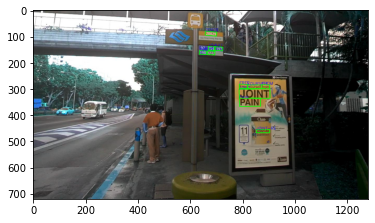

In [55]:
vis(im,word_instances)

In [ ]:
main(image_dir, results_dir)

PERFORMANCE TRACE - Gradient P5000 GPU
```
790608 function calls (790019 primitive calls) in 2.031 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        6    0.512    0.085    0.512    0.085 {method 'cpu' of 'torch._C._TensorBase' objects}
   175835    0.298    0.000    0.298    0.000 {built-in method editdistance.bycython.eval}
        3    0.291    0.097    0.754    0.251 <ipython-input-23-1199cd42a8ba>:153(match_lexicon)
   351670    0.165    0.000    0.165    0.000 {method 'upper' of 'str' objects}
        1    0.106    0.106    0.275    0.275 <ipython-input-9-99cfe1699790>:51(nms_with_char_cls)
        2    0.071    0.036    0.071    0.036 {pyclipper.scale_to_clipper}
    32024    0.050    0.000    0.050    0.000 {method 'AddPaths' of 'pyclipper.Pyclipper' objects}
    32024    0.050    0.000    0.050    0.000 {method 'Execute' of 'pyclipper.Pyclipper' objects}
     2685    0.047    0.000    0.074    0.000 <ipython-input-5-15dcc07f54f3>:3(rotate_rect)
        1    0.041    0.041    0.284    0.284 <ipython-input-23-1199cd42a8ba>:86(parse_word_bboxes)
    32024    0.040    0.000    0.040    0.000 {method 'AddPath' of 'pyclipper.Pyclipper' objects}
        1    0.036    0.036    0.193    0.193 <ipython-input-9-99cfe1699790>:6(nms)
        1    0.030    0.030    0.341    0.341 <ipython-input-23-1199cd42a8ba>:112(parse_char)
        1    0.016    0.016    0.016    0.016 {imread}
    32588    0.015    0.000    0.015    0.000 {built-in method builtins.len}
     2744    0.013    0.000    0.026    0.000 polygon.py:500(geos_polygon_from_py)
     2725    0.011    0.000    0.011    0.000 {built-in method numpy.array}
    21480    0.011    0.000    0.011    0.000 {built-in method math.cos}
     2933    0.011    0.000    0.019    0.000 topology.py:54(__call__)
     8058    0.010    0.000    0.010    0.000 {pyclipper.scale_from_clipper}
    21480    0.010    0.000    0.010    0.000 {built-in method math.sin}
     2744    0.010    0.000    0.010    0.000 {shapely.speedups._speedups.geos_linearring_from_py}
        1    0.009    0.009    0.009    0.009 {resize}
      103    0.009    0.000    0.009    0.000 {built-in method conv2d}
     2426    0.008    0.000    0.008    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.007    0.007    0.007    0.007 {method 'cuda' of 'torch._C._TensorBase' objects}
        1    0.007    0.007    0.048    0.048 <ipython-input-9-99cfe1699790>:10(<listcomp>)
    470/1    0.007    0.000    2.006    2.006 module.py:522(__call__)
     5612    0.007    0.000    0.007    0.000 base.py:222(empty)
    13687    0.007    0.000    0.007    0.000 {method 'append' of 'list' objects}
     2744    0.006    0.000    0.038    0.000 polygon.py:220(__init__)
     2933    0.006    0.000    0.027    0.000 base.py:435(area)
        1    0.005    0.005    0.034    0.034 <ipython-input-9-99cfe1699790>:56(<listcomp>)
       97    0.005    0.000    0.005    0.000 {built-in method batch_norm}
       62    0.005    0.000    0.005    0.000 topology.py:63(__call__)
        1    0.005    0.005    0.005    0.005 {method 'div' of 'torch._C._TensorBase' objects}
        1    0.004    0.004    0.004    0.004 {method 'clone' of 'torch._C._TensorBase' objects}
     2806    0.004    0.000    0.006    0.000 base.py:263(_geom)
        1    0.004    0.004    0.004    0.004 {method 'float' of 'torch._C._TensorBase' objects}
        1    0.004    0.004    0.004    0.004 <ipython-input-16-1e2fe7892184>:174(<lambda>)
     4029    0.004    0.000    0.004    0.000 {pyclipper.Area}
     2806    0.004    0.000    0.009    0.000 base.py:239(__del__)
     3057    0.004    0.000    0.005    0.000 topology.py:16(_validate)
     6114    0.003    0.000    0.003    0.000 base.py:259(_geom)
      143    0.003    0.000    0.003    0.000 {method 'encode' of 'ImagingEncoder' objects}
        1    0.003    0.003    0.003    0.003 {built-in method PIL._imaging.fill}
      490    0.003    0.000    0.024    0.000 <ipython-input-23-1199cd42a8ba>:215(match)
        1    0.003    0.003    2.004    2.004 <ipython-input-16-1e2fe7892184>:140(forward)
        1    0.003    0.003    0.003    0.003 {built-in method from_buffer}
        1    0.002    0.002    0.002    0.002 {method 'join' of 'bytes' objects}
        1    0.002    0.002    0.021    0.021 functional.py:43(to_tensor)
       94    0.002    0.000    0.002    0.000 {built-in method relu}
        1    0.002    0.002    0.002    0.002 {method 'decode' of 'ImagingDecoder' objects}
        1    0.002    0.002    0.002    0.002 {method 'div_' of 'torch._C._TensorBase' objects}
        1    0.002    0.002    0.002    0.002 {method 'sub_' of 'torch._C._TensorBase' objects}
        1    0.002    0.002    0.041    0.041 transforms.py:68(__call__)
        1    0.002    0.002    0.002    0.002 {method 'contiguous' of 'torch._C._TensorBase' objects}
        1    0.002    0.002    0.029    0.029 <ipython-input-23-1199cd42a8ba>:214(parse_words)
     2995    0.002    0.000    0.002    0.000 impl.py:56(__getitem__)
       41    0.002    0.000    0.025    0.001 <ipython-input-11-c297b3f69e4b>:47(forward)
     2933    0.002    0.000    0.002    0.000 {built-in method _ctypes.byref}
     2878    0.002    0.000    0.002    0.000 {built-in method builtins.isinstance}
     2744    0.001    0.000    0.001    0.000 {built-in method _ctypes.POINTER}
     1095    0.001    0.000    0.006    0.000 {method 'max' of 'numpy.ndarray' objects}
      777    0.001    0.000    0.001    0.000 module.py:562(__getattr__)
     1095    0.001    0.000    0.006    0.000 {method 'min' of 'numpy.ndarray' objects}
    119/9    0.001    0.000    0.030    0.003 container.py:98(forward)
     1095    0.001    0.000    0.004    0.000 _methods.py:28(_amax)
    70/64    0.001    0.000    0.002    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
       97    0.001    0.000    0.007    0.000 batchnorm.py:84(forward)
     1095    0.001    0.000    0.005    0.000 _methods.py:32(_amin)
      476    0.001    0.000    0.001    0.000 {built-in method torch._C._get_tracing_state}
     1059    0.001    0.000    0.001    0.000 {method 'values' of 'collections.OrderedDict' objects}
       62    0.001    0.000    0.002    0.000 base.py:73(geom_factory)
      103    0.001    0.000    0.009    0.000 conv.py:334(conv2d_forward)
      103    0.000    0.000    0.010    0.000 conv.py:344(forward)
       97    0.000    0.000    0.005    0.000 functional.py:1643(batch_norm)
      216    0.000    0.000    0.002    0.000 {method 'sum' of 'numpy.ndarray' objects}
        6    0.000    0.000    0.000    0.000 {built-in method torch._C._nn.upsample_bilinear2d}
      119    0.000    0.000    0.001    0.000 container.py:94(__iter__)
      6/2    0.000    0.000    0.027    0.013 <ipython-input-11-c297b3f69e4b>:68(forward)
       20    0.000    0.000    0.001    0.000 _methods.py:134(_mean)
      216    0.000    0.000    0.002    0.000 _methods.py:36(_sum)
       62    0.000    0.000    0.007    0.000 base.py:647(intersection)
       92    0.000    0.000    0.003    0.000 activation.py:93(forward)
        1    0.000    0.000    0.006    0.006 Image.py:677(tobytes)
        6    0.000    0.000    0.000    0.000 {built-in method max_pool2d}
       10    0.000    0.000    0.001    0.000 <ipython-input-23-1199cd42a8ba>:235(recog)
       68    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1009(_handle_fromlist)
       94    0.000    0.000    0.003    0.000 functional.py:904(relu)
       62    0.000    0.000    0.001    0.000 {built-in method builtins.__import__}
       97    0.000    0.000    0.000    0.000 batchnorm.py:248(_check_input_dim)
       12    0.000    0.000    0.000    0.000 {method 'argsort' of 'numpy.ndarray' objects}
       62    0.000    0.000    0.000    0.000 base.py:67(geometry_type_name)
       97    0.000    0.000    0.000    0.000 __init__.py:31(__get__)
      202    0.000    0.000    0.000    0.000 {built-in method builtins.hasattr}
       55    0.000    0.000    0.000    0.000 {built-in method numpy.zeros}
        1    0.000    0.000    0.009    0.009 functional.py:192(normalize)
       59    0.000    0.000    0.000    0.000 {method 'argmax' of 'numpy.ndarray' objects}
        6    0.000    0.000    0.001    0.000 functional.py:2420(interpolate)
       71    0.000    0.000    0.000    0.000 {method 'reshape' of 'numpy.ndarray' objects}
      163    0.000    0.000    0.000    0.000 {method 'dim' of 'torch._C._TensorBase' objects}
       10    0.000    0.000    0.755    0.075 <ipython-input-23-1199cd42a8ba>:165(filter_and_correct)
        1    0.000    0.000    0.001    0.001 <ipython-input-23-1199cd42a8ba>:249(<listcomp>)
      119    0.000    0.000    0.000    0.000 {built-in method builtins.iter}
       59    0.000    0.000    0.000    0.000 fromnumeric.py:55(_wrapfunc)
       49    0.000    0.000    0.001    0.000 <__array_function__ internals>:2(argmax)
       10    0.000    0.000    0.001    0.000 <ipython-input-23-1199cd42a8ba>:229(decode)
       49    0.000    0.000    0.000    0.000 fromnumeric.py:1112(argmax)
       97    0.000    0.000    0.000    0.000 {built-in method torch._C._get_cudnn_enabled}
        1    0.000    0.000    0.000    0.000 <ipython-input-9-99cfe1699790>:9(<listcomp>)
       62    0.000    0.000    0.000    0.000 {built-in method builtins.locals}
      123    0.000    0.000    0.000    0.000 {built-in method builtins.getattr}
        1    0.000    0.000    0.001    0.001 <ipython-input-16-1e2fe7892184>:43(forward)
        1    0.000    0.000    1.408    1.408 <ipython-input-23-1199cd42a8ba>:62(forward)
       10    0.000    0.000    0.000    0.000 <ipython-input-23-1199cd42a8ba>:231(<listcomp>)
        1    0.000    0.000    0.001    0.001 <ipython-input-16-1e2fe7892184>:70(forward)
        6    0.000    0.000    0.000    0.000 functional.py:2495(<listcomp>)
        1    0.000    0.000    0.000    0.000 <ipython-input-9-99cfe1699790>:55(<listcomp>)
        6    0.000    0.000    0.000    0.000 functional.py:2483(_output_size)
        2    0.000    0.000    0.000    0.000 {built-in method as_tensor}
        3    0.000    0.000    0.000    0.000 {method 'softmax' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    0.000    0.000 {method 'unsqueeze' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    2.031    2.031 {built-in method builtins.exec}
       20    0.000    0.000    0.000    0.000 _methods.py:50(_count_reduce_items)
        1    0.000    0.000    0.512    0.512 <ipython-input-16-1e2fe7892184>:96(to_numpy_or_none)
        6    0.000    0.000    0.000    0.000 utils.py:6(parse)
       62    0.000    0.000    0.000    0.000 geos.py:577(errcheck_predicate)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-1199cd42a8ba>:247(<listcomp>)
       20    0.000    0.000    0.001    0.000 {method 'mean' of 'numpy.ndarray' objects}
        1    0.000    0.000    2.031    2.031 <ipython-input-27-493bf72024d6>:16(predict_charnet)
       62    0.000    0.000    0.000    0.000 {built-in method builtins.globals}
        1    0.000    0.000    0.005    0.005 Image.py:2644(fromarray)
        6    0.000    0.000    0.000    0.000 {method 'numpy' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    0.005    0.005 functional.py:105(to_pil_image)
        6    0.000    0.000    0.001    0.000 <ipython-input-11-c297b3f69e4b>:69(<lambda>)
       49    0.000    0.000    0.000    0.000 fromnumeric.py:1108(_argmax_dispatcher)
        1    0.000    0.000    0.000    0.000 {method 'view' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    0.009    0.009 <ipython-input-27-493bf72024d6>:49(resize)
        1    0.000    0.000    0.755    0.755 <ipython-input-23-1199cd42a8ba>:152(filter_word_instances)
        1    0.000    0.000    2.031    2.031 <string>:1(<module>)
        6    0.000    0.000    0.000    0.000 pooling.py:138(forward)
        6    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:416(parent)
        1    0.000    0.000    0.000    0.000 Image.py:526(_new)
       20    0.000    0.000    0.000    0.000 _asarray.py:88(asanyarray)
       10    0.000    0.000    0.000    0.000 <ipython-input-23-1199cd42a8ba>:232(<listcomp>)
       10    0.000    0.000    0.000    0.000 {method 'dot' of 'numpy.ndarray' objects}
       40    0.000    0.000    0.000    0.000 {built-in method builtins.issubclass}
        6    0.000    0.000    0.000    0.000 _jit_internal.py:171(fn)
        3    0.000    0.000    0.000    0.000 numeric.py:90(zeros_like)
       12    0.000    0.000    0.000    0.000 {method 'size' of 'torch._C._TensorBase' objects}
       10    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(argsort)
       10    0.000    0.000    0.000    0.000 fromnumeric.py:997(argsort)
        1    0.000    0.000    0.002    0.002 Image.py:750(frombytes)
        1    0.000    0.000    0.000    0.000 Image.py:394(_getdecoder)
        2    0.000    0.000    0.000    0.000 {method 'transpose' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    0.003    0.003 Image.py:2508(new)
        1    0.000    0.000    0.009    0.009 transforms.py:167(__call__)
        1    0.000    0.000    0.000    0.000 functional.py:31(_is_tensor_image)
        2    0.000    0.000    0.000    0.000 {method 'round' of 'numpy.ndarray' objects}
       12    0.000    0.000    0.000    0.000 {built-in method math.floor}
        6    0.000    0.000    0.000    0.000 {built-in method _abc._abc_instancecheck}
        6    0.000    0.000    0.000    0.000 functional.py:482(_max_pool2d)
        1    0.000    0.000    0.005    0.005 Image.py:2547(frombytes)
        1    0.000    0.000    0.000    0.000 Image.py:415(_getencoder)
        2    0.000    0.000    0.001    0.001 <__array_function__ internals>:2(where)
        6    0.000    0.000    0.000    0.000 abc.py:137(__instancecheck__)
        2    0.000    0.000    0.000    0.000 Image.py:501(__init__)
        6    0.000    0.000    0.000    0.000 functional.py:2473(_check_size_scale_factor)
       10    0.000    0.000    0.000    0.000 <ipython-input-23-1199cd42a8ba>:35(__init__)
        1    0.000    0.000    0.001    0.001 <ipython-input-16-1e2fe7892184>:92(forward)
        1    0.000    0.000    0.000    0.000 grad_mode.py:37(__enter__)
        1    0.000    0.000    0.028    0.028 <ipython-input-11-c297b3f69e4b>:91(forward)
        6    0.000    0.000    0.000    0.000 {method 'rpartition' of 'str' objects}
        1    0.000    0.000    0.021    0.021 transforms.py:93(__call__)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(zeros_like)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(empty_like)
        2    0.000    0.000    0.000    0.000 {built-in method torch._C.is_grad_enabled}
        1    0.000    0.000    0.004    0.004 transforms.py:321(__call__)
        1    0.000    0.000    0.000    0.000 Image.py:781(load)
        3    0.000    0.000    0.000    0.000 functional.py:1202(softmax)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(copyto)
       10    0.000    0.000    0.000    0.000 {method 'join' of 'str' objects}
        3    0.000    0.000    0.000    0.000 Image.py:2490(_check_size)
        1    0.000    0.000    0.005    0.005 Image.py:2591(frombuffer)
        9    0.000    0.000    0.000    0.000 {method 'isalpha' of 'str' objects}
        1    0.000    0.000    0.000    0.000 grad_mode.py:41(__exit__)
        6    0.000    0.000    0.000    0.000 utils.py:5(_ntuple)
        1    0.000    0.000    0.000    0.000 __init__.py:116(is_tensor)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.max}
        1    0.000    0.000    0.005    0.005 transforms.py:127(__call__)
        1    0.000    0.000    0.000    0.000 {built-in method PIL._imaging.raw_decoder}
        1    0.000    0.000    0.000    0.000 grad_mode.py:137(__init__)
       10    0.000    0.000    0.000    0.000 fromnumeric.py:993(_argsort_dispatcher)
        2    0.000    0.000    0.000    0.000 {built-in method builtins.round}
        1    0.000    0.000    0.000    0.000 functional.py:24(_is_pil_image)
        1    0.000    0.000    0.000    0.000 functional.py:35(_is_numpy)
        1    0.000    0.000    0.000    0.000 <ipython-input-23-1199cd42a8ba>:254(<listcomp>)
        1    0.000    0.000    0.000    0.000 {built-in method PIL._imaging.raw_encoder}
        1    0.000    0.000    0.000    0.000 {method 'setimage' of 'ImagingDecoder' objects}
        1    0.000    0.000    0.000    0.000 {method 'setimage' of 'ImagingEncoder' objects}
        3    0.000    0.000    0.000    0.000 Image.py:522(size)
        3    0.000    0.000    0.000    0.000 numeric.py:86(_zeros_like_dispatcher)
        2    0.000    0.000    0.000    0.000 {built-in method torch._C.set_grad_enabled}
        1    0.000    0.000    0.000    0.000 {method 'ndimension' of 'torch._C._TensorBase' objects}
        1    0.000    0.000    0.000    0.000 {method 'pixel_access' of 'ImagingCore' objects}
        3    0.000    0.000    0.000    0.000 multiarray.py:77(empty_like)
        1    0.000    0.000    0.000    0.000 {method 'copy' of 'dict' objects}
        2    0.000    0.000    0.000    0.000 multiarray.py:312(where)
        3    0.000    0.000    0.000    0.000 multiarray.py:1043(copyto)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        1    0.000    0.000    0.000    0.000 {method 'get' of 'dict' objects}
```

PERFORMANCE TRACE - WSL2 - CPU

```
564470 function calls (562869 primitive calls) in 570.139 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      103  565.236    5.488  565.236    5.488 {built-in method conv2d}
       97    1.277    0.013    1.277    0.013 {built-in method batch_norm}
       94    0.915    0.010    0.915    0.010 {built-in method relu}
        6    0.798    0.133    0.798    0.133 {built-in method torch._C._nn.upsample_bilinear2d}
        6    0.710    0.118    0.710    0.118 {built-in method max_pool2d}
       41    0.417    0.010  517.869   12.631 <ipython-input-8-c297b3f69e4b>:47(forward)
      497    0.155    0.000    0.155    0.000 {method '_set_from_file' of 'torch._C.FloatStorageBase' objects}
      6/2    0.134    0.022  510.780  255.390 <ipython-input-8-c297b3f69e4b>:68(forward)
        3    0.104    0.035    0.104    0.035 {method 'softmax' of 'torch._C._TensorBase' objects}
 ...
        1    0.038    0.038    0.062    0.062 <ipython-input-7-e4a4e93bda4e>:14(load_lexicon)
    119/9    0.028    0.000  569.309   63.257 container.py:98(forward)
    470/1    0.016    0.000  569.691  569.691 module.py:540(__call__)
       21    0.013    0.001    0.013    0.001 {method 'uniform_' of 'torch._C._TensorBase' objects}
        1    0.011    0.011    0.011    0.011 {imread}
        1    0.009    0.009    0.009    0.009 {built-in method posix.listdir}
    87692    0.008    0.000    0.008    0.000 {method 'strip' of 'str' objects}
        1    0.006    0.006    0.006    0.006 {method 'div' of 'torch._C._TensorBase' objects}
        1    0.006    0.006    0.006    0.006 <ipython-input-9-2a07b2c012d0>:174(<lambda>)
        1    0.006    0.006    0.006    0.006 {method 'clone' of 'torch._C._TensorBase' objects}
 ...
        1    0.005    0.005  570.138  570.138 <ipython-input-12-beaa93c9e384>:9(main)
        1    0.004    0.004    0.004    0.004 {method 'float' of 'torch._C._TensorBase' objects}
        1    0.004    0.004    0.004    0.004 {resize}
        1    0.004    0.004    0.004    0.004 {method 'contiguous' of 'torch._C._TensorBase' objects}
        1    0.004    0.004    0.004    0.004 {method 'div_' of 'torch._C._TensorBase' objects}
        1    0.003    0.003    0.003    0.003 {method 'sub_' of 'torch._C._TensorBase' objects}
    470/1    0.002    0.000    0.167    0.167 module.py:824(load)
      497    0.002    0.000    0.003    0.000 serialization.py:713(persistent_load)
        1    0.002    0.002    0.002    0.002 {built-in method from_buffer}
 ...
        1    0.002    0.002    0.002    0.002 {method 'join' of 'bytes' objects}
      143    0.002    0.000    0.002    0.000 {method 'encode' of 'ImagingEncoder' objects}
        1    0.002    0.002  570.139  570.139 <string>:1(<module>)
        1    0.002    0.002    0.002    0.002 {method 'decode' of 'ImagingDecoder' objects}
       97    0.002    0.000    1.280    0.013 batchnorm.py:83(forward)
        1    0.002    0.002    0.002    0.002 {built-in method PIL._imaging.fill}
        1    0.001    0.001    0.009    0.009 {method 'load' of '_pickle.Unpickler' objects}
 ...
       97    0.001    0.000    1.278    0.013 functional.py:1905(batch_norm)
 ...
      103    0.001    0.000  565.236    5.488 conv.py:340(_conv_forward)
        1    0.001    0.001    0.167    0.167 serialization.py:613(_legacy_load)
 ...
      103    0.001    0.000  565.237    5.488 conv.py:348(forward)
       94    0.001    0.000    0.916    0.010 functional.py:1050(relu)
 ...
        1    0.001    0.001    0.001    0.001 <ipython-input-7-e4a4e93bda4e>:116(parse_char)
      497    0.001    0.000    0.005    0.000 _utils.py:134(_rebuild_tensor_v2)
        1    0.001    0.001   20.550   20.550 <ipython-input-9-2a07b2c012d0>:70(forward)
 ...
        1    0.000    0.000  520.054  520.054 <ipython-input-8-c297b3f69e4b>:91(forward)
       92    0.000    0.000    0.915    0.010 activation.py:93(forward)
    470/1    0.000    0.000    0.002    0.002 module.py:1055(train)
        1    0.000    0.000   15.057   15.057 <ipython-input-9-2a07b2c012d0>:43(forward)
       15    0.000    0.000    0.015    0.001 conv.py:20(__init__)
 ...
        1    0.000    0.000    0.043    0.043 transforms.py:59(__call__)
 ...
        1    0.000    0.000    0.020    0.020 functional.py:30(to_tensor)
 ...
        1    0.000    0.000    0.167    0.167 serialization.py:499(load)
 ...
        6    0.000    0.000    0.799    0.133 functional.py:2887(interpolate)
 ...
        1    0.000    0.000    0.001    0.001 <ipython-input-7-e4a4e93bda4e>:90(parse_word_bboxes)
 ...
        1    0.000    0.000  569.691  569.691 <ipython-input-9-2a07b2c012d0>:140(forward)
       48    0.000    0.000    0.000    0.000 {built-in method torch._C._log_api_usage_once}
        9    0.000    0.000    0.016    0.002 <ipython-input-9-2a07b2c012d0>:16(_conv3x3_bn_relu)
       39    0.000    0.000    0.000    0.000 {built-in method _make_subclass}
        1    0.000    0.000    0.013    0.013 functional.py:172(normalize)
       97    0.000    0.000    0.000    0.000 {built-in method torch._C._get_cudnn_enabled}
       15    0.000    0.000    0.014    0.001 conv.py:55(reset_parameters)
      497    0.000    0.000    0.000    0.000 serialization.py:129(_cpu_deserialize)
       15    0.000    0.000    0.013    0.001 init.py:295(kaiming_uniform_)
 ...
        1    0.000    0.000    0.004    0.004 Image.py:677(tobytes)
       27    0.000    0.000    0.000    0.000 {method 'zero_' of 'torch._C._TensorBase' objects}
 ...
        6    0.000    0.000    0.710    0.118 pooling.py:138(forward)
 ...
        6    0.000    0.000    0.710    0.118 _jit_internal.py:199(fn)
        6    0.000    0.000    0.799    0.133 <ipython-input-8-c297b3f69e4b>:69(<lambda>)
      507    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
       15    0.000    0.000    0.015    0.001 conv.py:329(__init__)
        6    0.000    0.000    0.710    0.118 functional.py:527(_max_pool2d)
        1    0.000    0.000   13.879   13.879 <ipython-input-9-2a07b2c012d0>:92(forward)
 ...
        1    0.000    0.000  570.139  570.139 {built-in method builtins.exec}
 ...
        1    0.000    0.000    0.062    0.062 <ipython-input-7-e4a4e93bda4e>:44(__init__)
        1    0.000    0.000    0.002    0.002 <ipython-input-7-e4a4e93bda4e>:62(forward)
        1    0.000    0.000    0.013    0.013 transforms.py:158(__call__)
        1    0.000    0.000    0.003    0.003 functional.py:85(to_pil_image)
        1    0.000    0.000    0.000    0.000 tarfile.py:1413(__init__)
 ...
        1    0.000    0.000    0.003    0.003 Image.py:2644(fromarray)
 ...
        1    0.000    0.000    0.004    0.004 <ipython-input-12-beaa93c9e384>:42(resize)
        1    0.000    0.000    0.167    0.167 module.py:796(load_state_dict)
 ...
```

## Resnet backbone --NOT USED --

**modeling/layers/misc.py**

In [26]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
"""
helper class that supports empty tensors on some nn functions.
Ideally, add support directly in PyTorch to empty tensors in
those functions.
This can be removed once https://github.com/pytorch/pytorch/issues/12013
is implemented
"""

import math
import torch
from torch.nn.modules.utils import _ntuple


class _NewEmptyTensorOp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, new_shape):
        ctx.shape = x.shape
        return x.new_empty(new_shape)

    @staticmethod
    def backward(ctx, grad):
        shape = ctx.shape
        return _NewEmptyTensorOp.apply(grad, shape), None


class Conv2d(torch.nn.Conv2d):
    def forward(self, x):
        if x.numel() > 0:
            return super(Conv2d, self).forward(x)
        # get output shape

        output_shape = [
            (i + 2 * p - (di * (k - 1) + 1)) // d + 1
            for i, p, di, k, d in zip(
                x.shape[-2:], self.padding, self.dilation, self.kernel_size, self.stride
            )
        ]
        output_shape = [x.shape[0], self.weight.shape[0]] + output_shape
        return _NewEmptyTensorOp.apply(x, output_shape)


class ConvTranspose2d(torch.nn.ConvTranspose2d):
    def forward(self, x):
        if x.numel() > 0:
            return super(ConvTranspose2d, self).forward(x)
        # get output shape

        output_shape = [
            (i - 1) * d - 2 * p + (di * (k - 1) + 1) + op
            for i, p, di, k, d, op in zip(
                x.shape[-2:],
                self.padding,
                self.dilation,
                self.kernel_size,
                self.stride,
                self.output_padding,
            )
        ]
        output_shape = [x.shape[0], self.bias.shape[0]] + output_shape
        return _NewEmptyTensorOp.apply(x, output_shape)


class BatchNorm2d(torch.nn.BatchNorm2d):
    def forward(self, x):
        if x.numel() > 0:
            return super(BatchNorm2d, self).forward(x)
        # get output shape
        output_shape = x.shape
        return _NewEmptyTensorOp.apply(x, output_shape)


def interpolate(
    input, size=None, scale_factor=None, mode="nearest", align_corners=None
):
    if input.numel() > 0:
        return torch.nn.functional.interpolate(
            input, size, scale_factor, mode, align_corners
        )

    def _check_size_scale_factor(dim):
        if size is None and scale_factor is None:
            raise ValueError("either size or scale_factor should be defined")
        if size is not None and scale_factor is not None:
            raise ValueError("only one of size or scale_factor should be defined")
        if (
            scale_factor is not None
            and isinstance(scale_factor, tuple)
            and len(scale_factor) != dim
        ):
            raise ValueError(
                "scale_factor shape must match input shape. "
                "Input is {}D, scale_factor size is {}".format(dim, len(scale_factor))
            )

    def _output_size(dim):
        _check_size_scale_factor(dim)
        if size is not None:
            return size
        scale_factors = _ntuple(dim)(scale_factor)
        # math.floor might return float in py2.7
        return [
            int(math.floor(input.size(i + 2) * scale_factors[i])) for i in range(dim)
        ]

    output_shape = tuple(_output_size(2))
    output_shape = input.shape[:-2] + output_shape
    return _NewEmptyTensorOp.apply(input, output_shape)

**modeling/backbone/decoder.py**

In [27]:
from torch import nn
from collections import OrderedDict
from torch.functional import F


class Decoder(nn.Module):
    def __init__(self, in_channels_list, out_channels):
        super(Decoder, self).__init__()
        self.backbone_feature_reduction = nn.ModuleList()
        self.top_down_feature_reduction = nn.ModuleList()
        for i, in_channels in enumerate(in_channels_list[::-1]):
            self.backbone_feature_reduction.append(
                self._conv1x1_relu(in_channels, out_channels)
            )
            if i < len(in_channels_list) - 2:
                self.top_down_feature_reduction.append(
                    self._conv1x1_relu(out_channels, out_channels)
                )

    def _conv1x1_relu(self, in_channels, out_channels):
        return nn.Sequential(OrderedDict([
            ("conv", nn.Conv2d(
                in_channels, out_channels,
                kernel_size=1, stride=1,
                bias=False
            )),
            ("relu", nn.ReLU())
        ]))

    def forward(self, x):
        x = x[::-1]  # to lowest resolution first
        top_down_feature = None
        for i, feature in enumerate(x):
            feature = self.backbone_feature_reduction[i](feature)
            if i == 0:
                top_down_feature = feature
            else:
                upsampled_feature = F.interpolate(
                    top_down_feature,
                    size=feature.size()[-2:],
                    mode='bilinear',
                    align_corners=True
                )
                if i < len(x) - 1:
                    top_down_feature = self.top_down_feature_reduction[i - 1](
                        feature + upsampled_feature
                    )
                else:
                    top_down_feature = feature + upsampled_feature
        return top_down_feature

**modeling/backbone/resnet.py**

In [28]:
#from charnet.modeling.layers import Conv2d

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved.
"""
Variant of the resnet module that takes cfg as an argument.
Example usage. Strings may be specified in the config file.
    model = ResNet(
        "StemWithFixedBatchNorm",
        "BottleneckWithFixedBatchNorm",
        "ResNet50StagesTo4",
    )
OR:
    model = ResNet(
        "StemWithGN",
        "BottleneckWithGN",
        "ResNet50StagesTo4",
    )
Custom implementations may be written in user code and hooked in via the
`register_*` functions.
"""
from collections import namedtuple

import torch
import torch.nn.functional as F
from torch import nn

EPS = 1e-5  # 0.0010000000474974513

# ResNet stage specification
StageSpec = namedtuple(
    "StageSpec",
    [
        "index",  # Index of the stage, eg 1, 2, ..,. 5
        "block_count",  # Number of residual blocks in the stage
        "return_features",  # True => return the last feature map from this stage
    ],
)

# -----------------------------------------------------------------------------
# Standard ResNet models
# -----------------------------------------------------------------------------
# ResNet-50 (including all stages)
ResNet50StagesTo5 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, False), (2, 4, False), (3, 6, False), (4, 3, True))
)
# ResNet-50 up to stage 4 (excludes stage 5)
ResNet50StagesTo4 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, False), (2, 4, False), (3, 6, True))
)
# ResNet-101 (including all stages)
ResNet101StagesTo5 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, False), (2, 4, False), (3, 23, False), (4, 3, True))
)
# ResNet-101 up to stage 4 (excludes stage 5)
ResNet101StagesTo4 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, False), (2, 4, False), (3, 23, True))
)
# ResNet-50-FPN (including all stages)
ResNet50FPNStagesTo5 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, True), (2, 4, True), (3, 6, True), (4, 3, True))
)
# ResNet-101-FPN (including all stages)
ResNet101FPNStagesTo5 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, True), (2, 4, True), (3, 23, True), (4, 3, True))
)
# ResNet-152-FPN (including all stages)
ResNet152FPNStagesTo5 = tuple(
    StageSpec(index=i, block_count=c, return_features=r)
    for (i, c, r) in ((1, 3, True), (2, 8, True), (3, 36, True), (4, 3, True))
)


class ResNet(nn.Module):
    def __init__(
            self,
            stem_module,
            stage_specs,
            transformation_module,
            stride_in_1x1
    ):
        super(ResNet, self).__init__()

        # If we want to use the cfg in forward(), then we should make a copy
        # of it and store it for later use:
        # self.cfg = cfg.clone()

        stem_out_channels = 64
        # Construct the stem module
        self.stem = stem_module(stem_out_channels)

        # Constuct the specified ResNet stages
        num_groups = 1
        width_per_group = 64
        stage2_bottleneck_channels = num_groups * width_per_group
        stage2_out_channels = 256
        self.stages = []
        self.return_features = {}
        in_channels = stem_out_channels
        for stage_spec in stage_specs:
            name = "layer" + str(stage_spec.index)
            stage2_relative_factor = 2 ** (stage_spec.index - 1)
            bottleneck_channels = stage2_bottleneck_channels * stage2_relative_factor
            out_channels = stage2_out_channels * stage2_relative_factor
            module = _make_stage(
                transformation_module,
                in_channels,
                bottleneck_channels,
                out_channels,
                stage_spec.block_count,
                num_groups,
                stride_in_1x1,
                first_stride=int(stage_spec.index > 1) + 1,
            )
            in_channels = out_channels
            self.add_module(name, module)
            self.stages.append(name)
            self.return_features[name] = stage_spec.return_features

    def _freeze_backbone(self, freeze_at):
        if freeze_at < 0:
            return
        for stage_index in range(freeze_at):
            if stage_index == 0:
                m = self.stem  # stage 0 is the stem
            else:
                m = getattr(self, "layer" + str(stage_index))
            for p in m.parameters():
                p.requires_grad = False

    def forward(self, x):
        outputs = []
        x = self.stem(x)
        for stage_name in self.stages:
            x = getattr(self, stage_name)(x)
            if self.return_features[stage_name]:
                outputs.append(x)
        return outputs


class ResNetHead(nn.Module):
    def __init__(
        self,
        block_module,
        stages,
        num_groups=1,
        width_per_group=64,
        stride_in_1x1=True,
        stride_init=None,
        res2_out_channels=256,
        dilation=1
    ):
        super(ResNetHead, self).__init__()

        stage2_relative_factor = 2 ** (stages[0].index - 1)
        stage2_bottleneck_channels = num_groups * width_per_group
        out_channels = res2_out_channels * stage2_relative_factor
        in_channels = out_channels // 2
        bottleneck_channels = stage2_bottleneck_channels * stage2_relative_factor

        self.stages = []
        stride = stride_init
        for stage in stages:
            name = "layer" + str(stage.index)
            if not stride:
                stride = int(stage.index > 1) + 1
            module = _make_stage(
                block_module,
                in_channels,
                bottleneck_channels,
                out_channels,
                stage.block_count,
                num_groups,
                stride_in_1x1,
                first_stride=stride,
                dilation=dilation
            )
            stride = None
            self.add_module(name, module)
            self.stages.append(name)
        self.out_channels = out_channels

    def forward(self, x):
        for stage in self.stages:
            x = getattr(self, stage)(x)
        return x


def _make_stage(
    transformation_module,
    in_channels,
    bottleneck_channels,
    out_channels,
    block_count,
    num_groups,
    stride_in_1x1,
    first_stride,
    dilation=1
):
    blocks = []
    stride = first_stride
    for _ in range(block_count):
        blocks.append(
            transformation_module(
                in_channels,
                bottleneck_channels,
                out_channels,
                num_groups,
                stride_in_1x1,
                stride,
                dilation=dilation
            )
        )
        stride = 1
        in_channels = out_channels
    return nn.Sequential(*blocks)


class Bottleneck(nn.Module):
    def __init__(
        self,
        in_channels,
        bottleneck_channels,
        out_channels,
        num_groups,
        stride_in_1x1,
        stride,
        dilation,
        norm_func
    ):
        super(Bottleneck, self).__init__()

        self.downsample = None
        if in_channels != out_channels:
            down_stride = stride if dilation == 1 else 1
            self.downsample = nn.Sequential(
                Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=down_stride, bias=False
                ),
                norm_func(out_channels, eps=EPS),
            )
            for modules in [self.downsample,]:
                for l in modules.modules():
                    if isinstance(l, Conv2d):
                        nn.init.kaiming_uniform_(l.weight, a=1)

        if dilation > 1:
            stride = 1 # reset to be 1

        # The original MSRA ResNet models have stride in the first 1x1 conv
        # The subsequent fb.torch.resnet and Caffe2 ResNe[X]t implementations have
        # stride in the 3x3 conv
        stride_1x1, stride_3x3 = (stride, 1) if stride_in_1x1 else (1, stride)

        self.conv1 = Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=stride_1x1,
            bias=True,
        )
        self.bn1 = norm_func(bottleneck_channels, eps=EPS)
        # TODO: specify init for the above

        self.conv2 = Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride_3x3,
            padding=dilation,
            bias=False,
            groups=num_groups,
            dilation=dilation
        )
        self.bn2 = norm_func(bottleneck_channels, eps=EPS)

        self.conv3 = Conv2d(
            bottleneck_channels, out_channels, kernel_size=1, bias=True
        )
        self.bn3 = norm_func(out_channels, eps=EPS)

        for l in [self.conv1, self.conv2, self.conv3,]:
            nn.init.kaiming_uniform_(l.weight, a=1)

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu_(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu_(out)

        out0 = self.conv3(out)
        out = self.bn3(out0)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu_(out)

        return out


class BaseStem(nn.Module):
    def __init__(self, out_channels, norm_func):
        super(BaseStem, self).__init__()

        self.conv1 = Conv2d(
            3, out_channels, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = norm_func(out_channels, eps=EPS)

        for l in [self.conv1,]:
            nn.init.kaiming_uniform_(l.weight, a=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu_(x)
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1)
        return x


class BottleneckWithBatchNorm(Bottleneck):
    def __init__(
        self,
        in_channels,
        bottleneck_channels,
        out_channels,
        num_groups=1,
        stride_in_1x1=True,
        stride=1,
        dilation=1
    ):
        super(BottleneckWithBatchNorm, self).__init__(
            in_channels=in_channels,
            bottleneck_channels=bottleneck_channels,
            out_channels=out_channels,
            num_groups=num_groups,
            stride_in_1x1=stride_in_1x1,
            stride=stride,
            dilation=dilation,
            norm_func=nn.BatchNorm2d
        )


class StemWithBatchNorm(BaseStem):
    def __init__(self, out_channels):
        super(StemWithBatchNorm, self).__init__(
            out_channels, norm_func=nn.BatchNorm2d
        )


def resnet50():
    return ResNet(
        stem_module=StemWithBatchNorm,
        stage_specs=ResNet50FPNStagesTo5,
        transformation_module=BottleneckWithBatchNorm,
        stride_in_1x1=True
    )


def main_resnet():
    from charnet.modeling.backbone.decoder import Decoder
    model = resnet50()
    decoder = Decoder([256, 512, 1024, 2048], 256)

    # for k, _ in model.named_parameters():
    #     print(k)
    # for k, _ in model.named_buffers():
    #     print(k)
    # exit(0)

    # missing_keys, unexpected_keys = model.load_state_dict(torch.load("/home/zhitian/code/charnet/src/resnet50_from_mxnet_charnet.pth"))
    # from IPython import embed
    # embed()
    im = torch.ones((1, 3, 1025, 513))  # .cuda()
    # model.cuda()
    model.eval()
    outputs = model(im)
    for o in outputs:
        print(o.mean(), o.size())
    decoder(outputs)